# Assignment 4, part 2
## Instructor: Nidhi Hegde

## Instructions
**Reminder.** You must submit your own work.  The collaboration policy for the assignments is Consultation Collaboration. You may verbally discuss concepts with your classmates, without exchanging written text, code, or detailed advice.  You must develop your own solution and submit your own work.  All sources of information used including books, websites, students you talked to, must be cited in the submission.  Please see the course FAQ document for details on this collaboration policy.  We will adhere to current Faculty of Science guidelines on dealing with suspected cases of plagiarism.

You must use this notebook to complete your assignment. You will execute the questions in the notebook. The questions might ask for a short answer in text form or for you to write and execute a piece of code. Make sure you enter your answer in either case only in the cell provided.

Incase any of the packages are not installed on your local system run the following command on your command line and make sure the `requirements.txt` file is also downloaded.
```bash
pip install -r requirements.txt
```

Your submitted notebook should run on our local installation.  So if you are importing packages not listed in the notebook or using local data files not included in the assignment package, make sure the notebook is self-contained with a requirements.txt file or cells in the notebook itself to install the extra packages.  If we cannot run your notebook, you will lose 50% of the marks, and any additional marks that may be lost due to wrong answers.

### Submission Instructions
When you are done, you will submit your work from the notebook. Make sure to save your notebook before running it, and then submit on eClass the notebook file with your work completed. Name your file with your lastname and the assignment number: Lastname_A4-2.ipynb

# Assignment 4: Fairness analysis of the COMPAS Tool

We will consider the fairness case study we examined in class, the ProPublica [investigation](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) of the Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) tool used in Broward county, Florida, for judicial hearings. COMPAS generates a risk assessment for defendants in a criminal trial, which is then used by judges to decide on bail, jail, sentencing, etc.  As with the ProPublica analysis, we will fcus on the recidivism score.  This score is claimed to give a likelihood of an individual recidivating (committing another crime) within the following two years of the assessment.

In this lab, we will go through parts of ProPublica's analysis of COMPAS, focusing on how the recidivism risk scale varies by race and sex.

This notebook has four stages in which we will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the COMPAS recidivism score, our primary variable of interest
3. Reproduce the logistic regression model in ProPublica's analysis and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

In [263]:
# Don't change this cell; just run it.
%pip install -r requirements.txt
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm

# These lines do some fancy plotting magic.
import matplotlib
# This is a magic function that renders the figure in the notebook, instead of displaying a dump of the figure object.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

Note: you may need to restart the kernel to use updated packages.


In [264]:
# Don't change this cell; just run it.
rng_seed = 42
rng = default_rng(rng_seed)
rngstate = np.random.RandomState(rng_seed)

In [265]:
# Downloading the data files from Google Drive
%pip install --upgrade gdown
import gdown
url = "https://drive.google.com/drive/folders/1wQZ8Y6pBGI4UFMb9WZNQa69vM8o7IRmA?usp=drive_link"
gdown.download_folder(url)

Note: you may need to restart the kernel to use updated packages.


Retrieving folder contents


Processing file 1zoUwZCxyT80QPM8UHrXXhJT6TdouES_O compas_data_two_years.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1zoUwZCxyT80QPM8UHrXXhJT6TdouES_O
To: c:\Users\shris\Documents\Classes\CMPUT 200\A4-2\data\compas_data_two_years.csv
100%|██████████| 2.54M/2.54M [00:00<00:00, 6.05MB/s]
Download completed


['c:\\Users\\shris\\Documents\\Classes\\CMPUT 200\\A4-2\\data\\compas_data_two_years.csv']

# Part 1
This part should have been completed as part of Assignment 4-1.  If you have not done it for the submission of Assignment 4-1, you will need to do it now.  This part is not marked for Assignment 4-2.

## Data
We will first load the data, carry out some cleaning and pre-processing, and inspect the data to understand what exploratory steps we will take.

Note that we will use the dataset provided by publica on their github site.  Rather than download the data locally, we will pull the data directly from the github site.  There are a few datasets on the github repository, but we will use one specific one.  The url for the dataset is [https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv](https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv)

In [266]:
df_init = pd.read_csv("compas_data_two_years.csv")
print("Shape: ", df_init.shape)
df_init.head(5)

Shape:  (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In class we exmained the data collection methodology of the ProPublica investigation and analysis.  Make sure you have read through their [methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).  It is crucial, in every data analysis project, to have a good understanding of the data.  This includes:  how the data was collected, what sources the data originate from, how data were merged, what the data columns refer to, etc.  You will note that the ProPublica team combined COMPAS tool data they received from a public records request, with public criminal records from the Broward County Clerk’s Office to create the profiles for the individuals in the dataset.  The COMPAS tool output data includes at least three COMPAS scores: "Risk of Recidivism," "Risk of Violence" and "Risk of Failure to Appear". COMPAS scores for each defendant ranged from 1 to 10, with 10 being the highest risk. Scores from 1 to 4 were labeled by the tool as "Low," 5 to 7 were labeled “Medium," and 8 to 10 were labeled “High.”

### Data pre-processing
We will follow ProPublica's methodology in pre-processing the data.  Note that the data we imported was already filtered so that only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility were included.  In their pre-processing, they first retain only relevant columns, for ease of analysis and inspection.  Then they remove several rows due to missing data.  Form their analysis (paraphrased and commented):
- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, we do not have the right offense. (keep rows `days_b_screening_arrest <= 30` and `days_b_screening_arrest >= -30` )
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all. ( keep rows where `is_recid` is not -1)
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them). (keep rows where `c_charge_degree` is not "O" - note this is the letter O)


We also want to filter out any "N/A" in the `score_text` - note that this column contains strings.

In [267]:
cols_retain = ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]
# Your solution here
df = df_init[cols_retain].copy()
df = df[df["days_b_screening_arrest"] <= 30]
df = df[df["days_b_screening_arrest"] >= -30]
df = df[df["is_recid"] != -1]
df = df[df["c_charge_degree"] != "O"]
df = df[df["score_text"] != "N/A"]
print("Shape: ", df.shape)
df.head(5)

Shape:  (6172, 13)


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


We will be working with decile_score, which represents the score that the COMPAS tool generates for the individuals.  Let's first be certain the values are numeric.  You would use `pd.to_numeric`.  Note that there might be NaN values, and if so, you should drop those rows.

In [268]:
# Your solution here
df = df.dropna()
pd.to_numeric(df["decile_score"])
df.shape

(6172, 13)

### Data exploration
Let us now explore the statistics of the data.  The compas data includes the `decile_score` which is the score calculated by the COMPAS tool.  Our goal is to compare the analysis of this score, with the outputs of a logistic regression model we will build ourselves.

We will  plot the distribution of the score, according to race to see how they differ.


Let's first create dataframes that are specific to the two races.  In the cell below, create the new dataframes `df_black` and `df_white` so that `df_black` holds all the rows that correspond to the race being "African-American" and `df_white` holds all the rows that correspond to the race being "Caucaisian".

In [269]:
df_black = df.loc[df["race"]=="African-American"]
df_white = df.loc[df["race"]=="Caucasian"]

Now we will plot histograms for these two dataframes.  The histogram will have the Decile Score on the x axis, 10 bins corresponding to the 10 values and the y axis will be the _proportion_ of individuals of each race that have that decile score.  So the y values for each race will be the number of individuals having a given score divided by the total number of individuals of that race.

You can choose how you want to represent the histograms: two separate sub plots side by side, or both on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

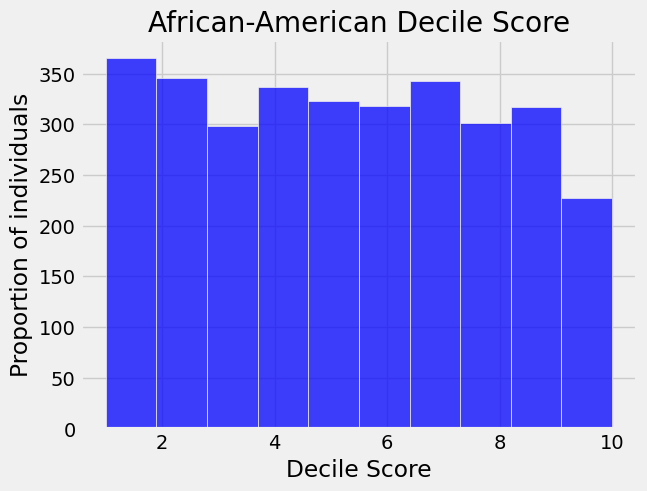

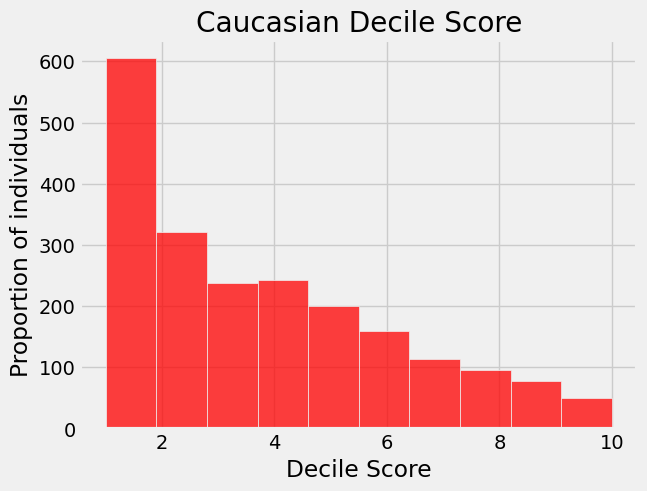

In [270]:
# Your solution here
df_black['decile_score'].value_counts(normalize=True)
sns.histplot(df_black['decile_score'], bins=10,color='blue')
plt.title("African-American Decile Score")
plt.xlabel("Decile Score")
plt.ylabel("Proportion of individuals")
plt.show()

df_white['decile_score'].value_counts(normalize=True)
sns.histplot(df_white['decile_score'], bins=10,color='red')
plt.title("Caucasian Decile Score")
plt.xlabel("Decile Score")
plt.ylabel("Proportion of individuals")
plt.show()

#### Question 1
Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the decile scores with respect to the senstive feature race?



Firstly, the amount of African Americans is much lower compared to the Caucasians. Next, the African Americans are very similarly distributed amongst all the decile scores which means there is a really high rate of African Americans who are charged with crime, compared to the Caucasians who have the highest amount in 0-1, which means very less Caucasians get charged with crimes.
This means that African Americans are more likely to be charged compared to Caucasians

#### Question 2
We will now consider gender.  Follow the same steps as above, now for the gender feature.

Create dataframes that are specific to the two races.  In the cell below, create the new dataframes `df_male` and `df_female` so that `df_male` holds all the rows that correspond to the sex being "Male" and `df_female` holds all the rows that correspond to the sex being "Female".

In [271]:
df_male = df.loc[df["sex"]=="Male"]
df_female = df.loc[df["sex"]=="Female"]

Now we will plot histograms for these two dataframes.  The histogram will have the Decile Score on the x axis, 10 bins corresponding to the 10 values and the y axis will be the _proportion_ of individuals of each sex that have that decile score.  So the y values for each sex will be the number of individuals having a given score divided by the total number of individuals of that sex.

You can choose how you want to represent the histograms: two separate sub plots side by side, or both on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

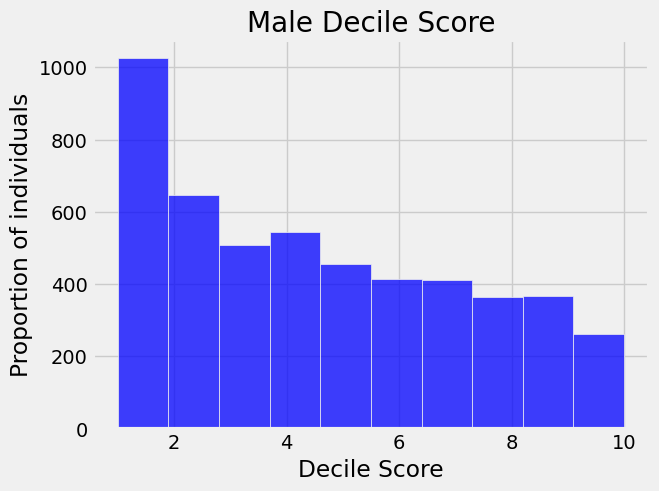

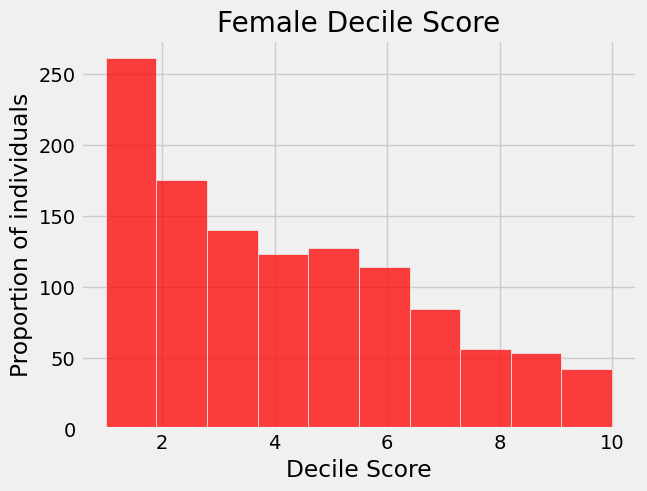

In [272]:
# Your solution here
df_male['decile_score'].value_counts(normalize=True)
sns.histplot(df_male['decile_score'], bins=10,color='blue')
plt.title("Male Decile Score")
plt.xlabel("Decile Score")
plt.ylabel("Proportion of individuals")
plt.show()

df_female['decile_score'].value_counts(normalize=True)
sns.histplot(df_female['decile_score'], bins=10,color='red')
plt.title("Female Decile Score")
plt.xlabel("Decile Score")
plt.ylabel("Proportion of individuals")
plt.show()

#### Question 3
Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the decile scores with respect to the senstive feature sex?

The histograms are both very similar, with the female values being slightly lesser than the males, but the biggest noticable difference is the male population is 4 times higher compared to the male so that could possibly contribute to the female distribution looking so similar to the male one.

# Part 2
This part is marked for Assignment 4-2

## Fairness / Bias in COMPAS

Now we will develop our own logistic regression model to predict a risk value given the data and see how it does with respect to fairness metrics.

#### Pre-processing
We first have some preprocessing to do.

Logistic regression is used here as a classification algorithm, so will give binary outputs.  The COMPAS data contains a `score_text` column, which has values `low`, `medium`, `high`.  This category is used by the judicial decision makers, where a risk of `low` means the person has low likelihood of recidivism and a risk of `medium` or `high` means the person has high likelihood of recidivism.  We will compare our model's output with this score that is the output from COMPAS.  Our model's output of 0 will correspond to `low` in the `score-text` column, and an output of 1 will correspond to `medium` or `high` in the `score-text` column.

The label for our model will be the true label of whether an individual recidivated or not, which is shown in the feature `two_year_recid`.  A value of 0 indicates the individual did not recidivate and 1 indicates they did.

We will use `sklearn`'s logistic regression model which takes numerical input.  So we will have to convert the categorical features to numerical features.  We will use one-hot encoding for this.


Let's first set up a dataframe for the label, or target values.  This will be the column `two-year_recid`.  In the cell below extract that column into a separate dataframe, our target dataframe.

In [273]:
Y = df["two_year_recid"]

Now let's set up the remaining data - we will first drop the target column

In [274]:
# just run this cell
X=df.drop(columns="two_year_recid")

The ProPublica analysis further used only certain features.  We will use the same.  There are: `priors_count`, `c_charge_degree`, `age_cat`, `race`, `sex`.  In the next cell, retain only these columns in our features dataframe `X`.

In [275]:
# now write code to retain only the above listed columns
cols_retain = ["priors_count","c_charge_degree","age_cat","race","sex"]
X = df[cols_retain].copy()

Since we will use `sklearn`'s logistic regression model, we need all our data to be numerical values.  Let's first examine the column types.

Run the following cell to examine the data.

In [276]:
X.dtypes

priors_count        int64
c_charge_degree    object
age_cat            object
race               object
sex                object
dtype: object

A data type of `object` indicates that the column is categorical.  We will need to convert these to numerical.  We will use one hot encoding on the categorical features. We first separate the numerical and categorical featues using `selector`.  Then we transform the categorial features using one hot encoding and we normalize the numerical features using a sclaer.  See for instance here for help on this step: <https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py>

In [277]:
# we will need the following modules
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
# Your solution here
numeric_features = ["priors_count"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["c_charge_degree","age_cat","race","sex"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Now we set up the pipeline for our model.  You can refer to the url provided above for help with this step.  You may also need to set `max_iter` to make sure the model converges.


In [278]:
# make sure you import the models needed for this 
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000))]
)

Now split your dataset into train and test datasets, with the test set being 25% of the whole dataset.

In [279]:
# import the module
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [280]:
# now we run the logistic regression we have set up
# Just run this cell

model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['priors_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x0000028C6D318040>))]),
                                                  ['c_charge_degree', 'age_cat',
                                                   'race', 'sex'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

Let's now predict on the test set and see what the performance metrics are.

In [281]:
## write code to run the model on the test set;
## after running this cell, Y_test holds the true class labels for the test set
## set Y_pred to be the predicted labels
Y_pred = model.predict(X_test)

### Fairness metrics

Let's now examine the fairness metrics of this classifier.

Let's first convert `Y_pred` into a DataFrame for use later.

We will first extract the sensitive features into a new dataframe, `A`.  Since we are examining results on the test set, we extract this from `X_test`.

In [282]:
Y_pred = pd.DataFrame(Y_pred, Y_test.index)
Y_pred.head()

,0
2004,0
660,0
4044,1
146,1
1485,0


In [283]:
# Just run this cell
# we will import packages we may need
from sklearn.metrics import confusion_matrix

In [284]:
# In this cell, extract the sensitive features race, sex, age_cat into A

A = X_test[['race', 'sex', 'age_cat']]

Now let's write some functions to calculate the fairness metrics.  In particular, we want to calculate the True positive and false positive rates, and the positive label rate.

In [285]:
def tpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    tpr : float
        The true positive rate for the individuals with s_feature = s_value

    For example, calling tpr_metric(Y_test, Y_pred, x, "race","African-American") should return
    the true positive rate for African-Americans.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''

    tpr=0
    # Your solution here
    y_true = y_true.loc[x[s_feature]==s_value]
    y_pred = y_pred.loc[x[s_feature]==s_value]
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm[1][1]/(cm[1][1]+cm[1][0])
    return tpr

In [286]:
def fpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    fpr : float
        The false positive rate for the individuals with s_feature = s_value

    For example, calling fpr_metric(Y_test, Y_pred, x, "race","African-American") should return
    the false positive rate for African-Americans.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''

    fpr=0
    # Your solution here
    y_true = y_true.loc[x[s_feature]==s_value]
    y_pred = y_pred.loc[x[s_feature]==s_value]
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm[0][1]/(cm[0][1]+cm[0][0])
    return fpr

In [287]:
def poslabel_metric(y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    poslabel : float
        The rate of a positive label for the individuals with s_feature = s_value
        This is P[y_pred=1|s_featue=s_value]

    For example, calling poslabel_metric(y_pred,x, "race","African-American") should return
    the rate of positive labels for African-Americans.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_pred and x should correspond to the same rows, for example these could be Y_pred and X_test
    '''

    poslabel=0
    # Your solution here
    y_pred = y_pred.loc[x[s_feature]==s_value]
    poslabel = y_pred.value_counts(normalize=True)
    poslabel = poslabel[0]
    return poslabel

You now have the functions necessary to determine the fairness metrics.
We will examine the difference in the parity definitions.
Specifically, we look at the following:
- demographic parity difference:  the gap in demographic parity between two given subgroups.  Here, it means the difference in the rate of positive label ( Pr[Y_pred = 1 | A=1] - \Pr[Y_pred = 1 | A=0] when asked for the difference between subgroups 1 and 0.)
- equal opportunity difference:  the difference in true positive rates
- equalized odds difference:  the difference in true positive rates and false positive rates. The output here is a vector.

For each of the following, write code to compute the metrics and write in text form your explanation of what you see - describe the metrics.  Is our model fair?  Why or why not?

1. Race:  African-American vs Caucasian
    a. Demographic parity difference
    b. Equal opportunity diference
    c. Equalized odds difference
2. Sex:  Male vs Female
    a. Demographic parity difference
    b. Equal opportunity diference
    c. Equalized odds difference
3. Age_cat:  Greater than 45 vs Less than 25
    a. Demographic parity difference
    b. Equal opportunity diference
    c. Equalized odds difference

In [288]:
def demo_par_diff(y_true, y_pred, x, s_feature, s_value1, s_value2):
    pl1 = poslabel_metric(y_pred, x, s_feature, s_value1)
    pl2 = poslabel_metric(y_pred, x, s_feature, s_value2)
    return abs(pl1 - pl2)

In [289]:
def eq_opp_diff(y_true, y_pred, x, s_feature, s_value1, s_value2):
    tpr1 = tpr_metric(y_true, y_pred, x, s_feature, s_value1)
    tpr2 = tpr_metric(y_true, y_pred, x, s_feature, s_value2)
    return abs(tpr1 - tpr2)

In [290]:
def eq_odd_diff(y_true, y_pred, x, s_feature, s_value1, s_value2):
    tpr1 = tpr_metric(y_true, y_pred, x, s_feature, s_value1)
    tpr2 = tpr_metric(y_true, y_pred, x, s_feature, s_value2)
    tpr_diff = abs(tpr1 - tpr2)
    fpr1 = fpr_metric(y_true, y_pred, x, s_feature, s_value1)
    fpr2 = fpr_metric(y_true, y_pred, x, s_feature, s_value2)
    fpr_diff = abs(fpr1 - fpr2)
    return max(tpr_diff, fpr_diff)

In [291]:
# Code and explanation for 1 here
s_feature ='race'
s_value1 = 'African-American'
s_value2 = 'Caucasian'
dpd = demo_par_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
eod = eq_opp_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
eqod = eq_odd_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
print("For race (African-Americans vs Caucasians):")
print("Demographic parity difference:", dpd)
print("Equal opportunity difference:", eod)
print("Equalized odds difference: ", eqod)

For race (African-Americans vs Caucasians):
Demographic parity difference: 0.2015975249066002
Equal opportunity difference: 0.198502777106979
Equalized odds difference:  0.198502777106979


The demographic parity difference, the equal opportunity difference and the equalized odds difference are all 0.02.
Considering how close the values are to 0, this shows that the model is not biased and treats African-Americans and Caucasians almost equally.

In [292]:
# Code and explanation for 2 here
s_feature ='sex'
s_value1 = 'Male'
s_value2 = 'Female'
dpd = demo_par_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
eod = eq_opp_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
eqod = eq_odd_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
print("For sex (Male vs Female):")
print("Demographic parity difference:", dpd)
print("Equal opportunity difference:", eod)
print("Equalized odds difference: ", eqod)

For sex (Male vs Female):
Demographic parity difference: 0.3173422623671186
Equal opportunity difference: 0.3539978094194962
Equalized odds difference:  0.3539978094194962


The demographic parity difference, the equal opportunity difference and the equalized odds difference are all 0.03.
Considering how close the values are to 0, this shows that the model is not very biased and treats males and females almost equally.

In [293]:
# Code and explanation for 3 here
s_feature ='age_cat'
s_value1 = 'Greater than 45'
s_value2 = 'Less than 25'
dpd = demo_par_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
eod = eq_opp_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
eqod = eq_odd_diff(Y_test, Y_pred, X_test, s_feature, s_value1, s_value2)
print("For age (>45 vs <25):")
print("Demographic parity difference:", dpd)
print("Equal opportunity difference:", eod)
print("Equalized odds difference: ", eqod)

For age (>45 vs <25):
Demographic parity difference: 0.5045651389390111
Equal opportunity difference: 0.41839290875806917
Equalized odds difference:  0.5068493150684932


The demographic parity difference and the equalized odds difference are all 0.05 while the equal opportunity difference is 0.4.
Considering how the values are not as close to 0, this shows that the model may be slightly biased and does not treat people older than 45 and those younger than 25 equally.

In [294]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       852
           1       0.64      0.53      0.58       691

    accuracy                           0.66      1543
   macro avg       0.65      0.65      0.65      1543
weighted avg       0.66      0.66      0.65      1543

